In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('transactions.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,8,CASH_OUT,158007.12,C424875646,0.00,0.00,C1298177219,474016.32,1618631.97,0
1,236,CASH_OUT,457948.30,C1342616552,0.00,0.00,C1323169990,2720411.37,3178359.67,0
2,37,CASH_IN,153602.99,C900876541,11160428.67,11314031.67,C608741097,3274930.56,3121327.56,0
3,331,CASH_OUT,49555.14,C177696810,10865.00,0.00,C462716348,0.00,49555.14,0
4,250,CASH_OUT,29648.02,C788941490,0.00,0.00,C1971700992,56933.09,86581.10,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199999 entries, 0 to 199998
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            199999 non-null  int64  
 1   type            199999 non-null  object 
 2   amount          199999 non-null  float64
 3   nameOrig        199999 non-null  object 
 4   oldbalanceOrg   199999 non-null  float64
 5   newbalanceOrig  199999 non-null  float64
 6   nameDest        199999 non-null  object 
 7   oldbalanceDest  199999 non-null  float64
 8   newbalanceDest  199999 non-null  float64
 9   isFraud         199999 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 15.3+ MB


In [4]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,199999.000000,1.999990e+05,1.999990e+05,1.999990e+05,1.999990e+05,1.999990e+05,199999.000000
mean,243.289836,1.802425e+05,8.314361e+05,8.523333e+05,1.093644e+06,1.218886e+06,0.001410
std,141.800473,6.255482e+05,2.882314e+06,2.917352e+06,3.302878e+06,3.627192e+06,0.037524
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,156.000000,1.338746e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,238.000000,7.426695e+04,1.420100e+04,0.000000e+00,1.320572e+05,2.138098e+05,0.000000
75%,334.000000,2.086376e+05,1.078489e+05,1.449629e+05,9.410291e+05,1.109082e+06,0.000000
max,741.000000,5.204280e+07,5.039905e+07,4.039905e+07,2.359327e+08,3.114049e+08,1.000000


In [5]:
print(df['isFraud'].value_counts())

isFraud
0    199717
1       282
Name: count, dtype: int64


C:\Users\HP\AppData\Local\Temp\ipykernel_17144\235340276.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='isFraud', data=df, palette='Set2')


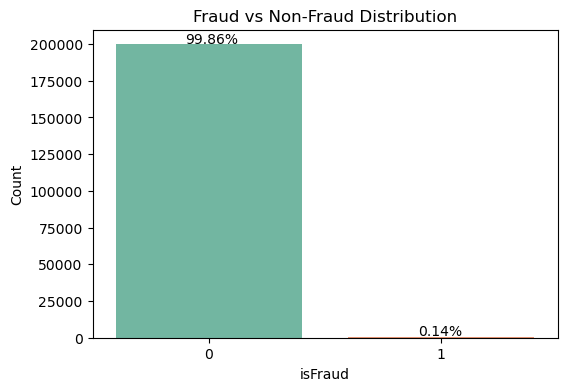

In [6]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='isFraud', data=df, palette='Set2')

# Add percentage
total = len(df)
for p in ax.patches:
    count = p.get_height()
    percentage = f"{100 * count / total:.2f}%"
    ax.annotate(percentage, (p.get_x() + 0.3, count + total * 0.005))

plt.title('Fraud vs Non-Fraud Distribution')
plt.xlabel('isFraud')
plt.ylabel('Count')
plt.show()

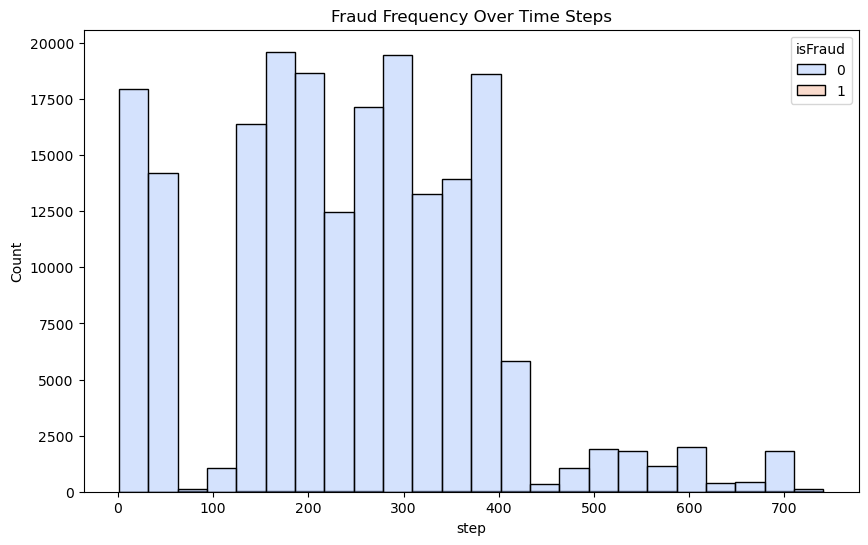

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='step', hue='isFraud', bins=24,
             kde=False, palette='coolwarm')
plt.title('Fraud Frequency Over Time Steps')
plt.show()

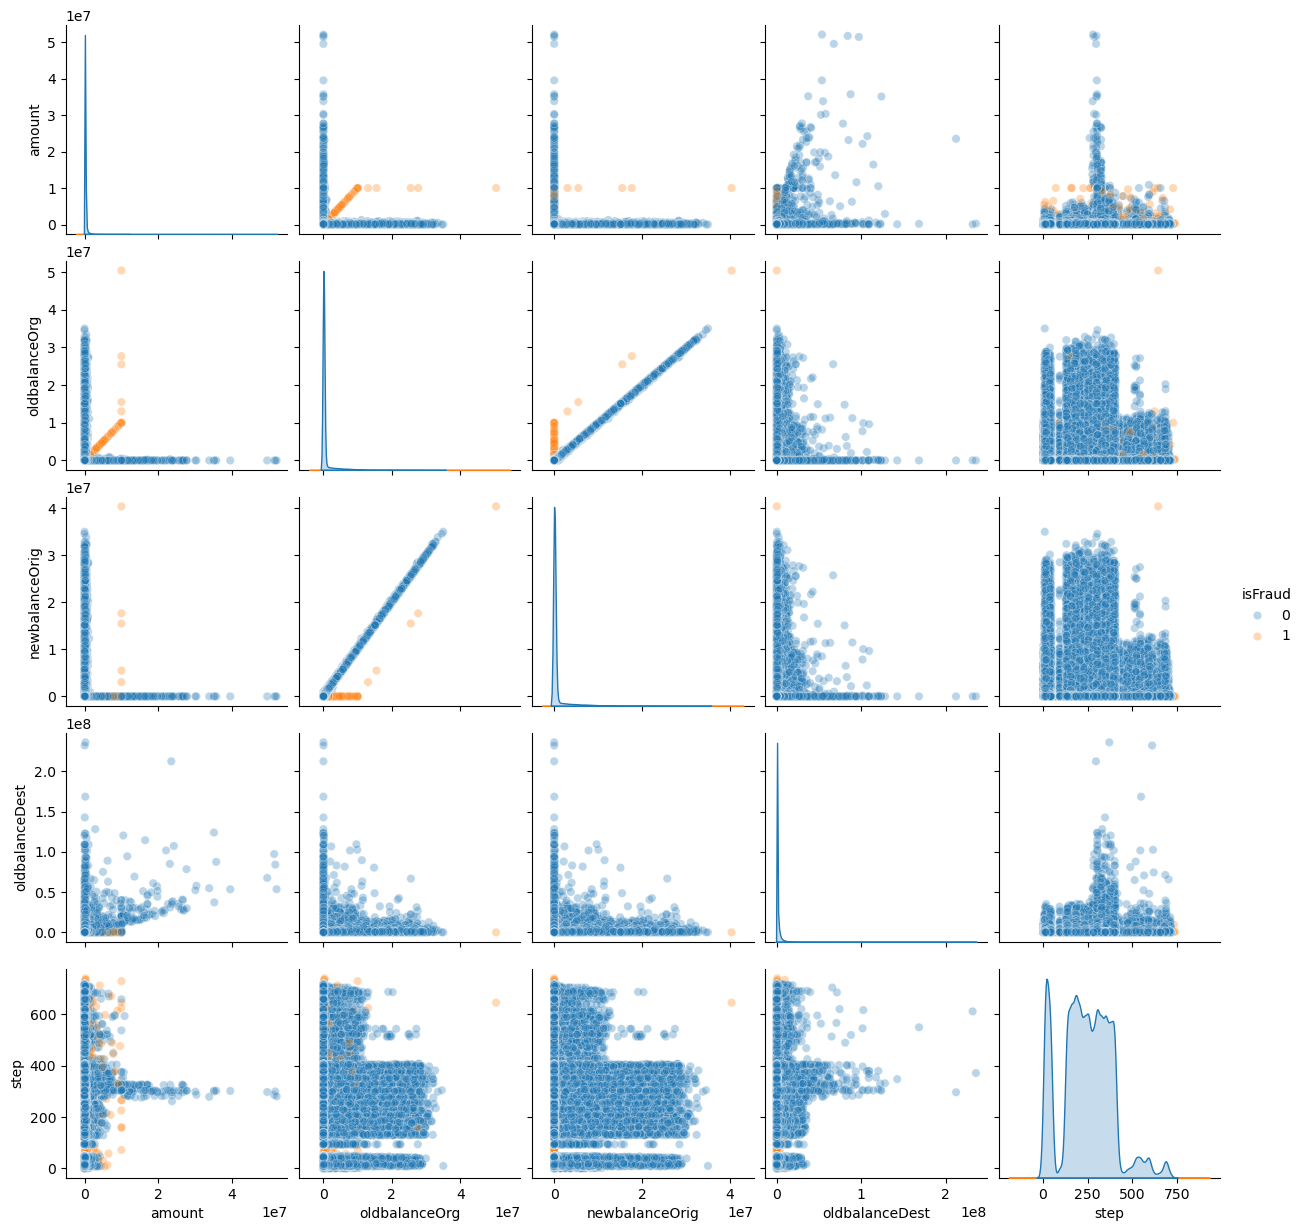

In [8]:
selected = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'step', 'isFraud']

sns.pairplot(df[selected], hue='isFraud', diag_kind='kde', plot_kws={'alpha': 0.3})
plt.show()

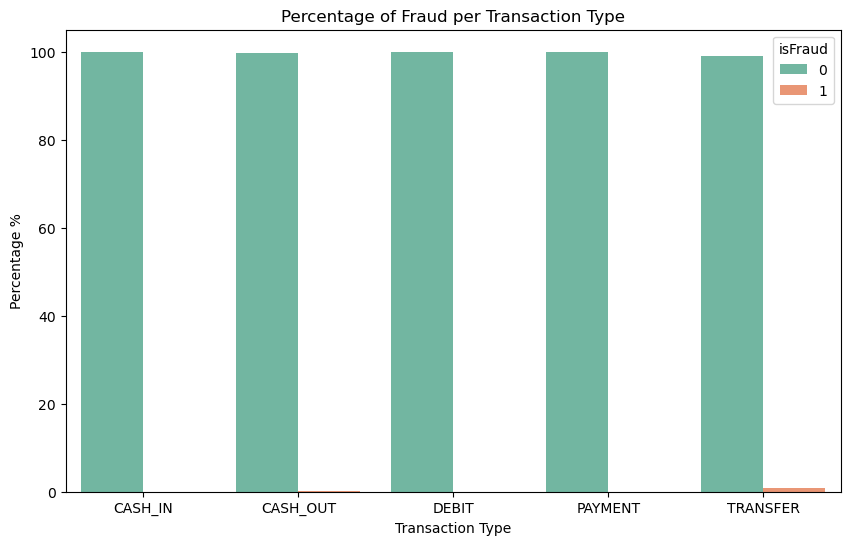

In [9]:
plt.figure(figsize=(10, 6))
type_fraud = df.groupby(['type', 'isFraud']).size().reset_index(name='count')
type_total = df.groupby('type').size().reset_index(name='total')
merged = type_fraud.merge(type_total, on='type')
merged['percent'] = merged['count'] / merged['total'] * 100

sns.barplot(x='type', y='percent', hue='isFraud',
            data=merged, palette='Set2')

plt.title('Percentage of Fraud per Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Percentage %')
plt.show()


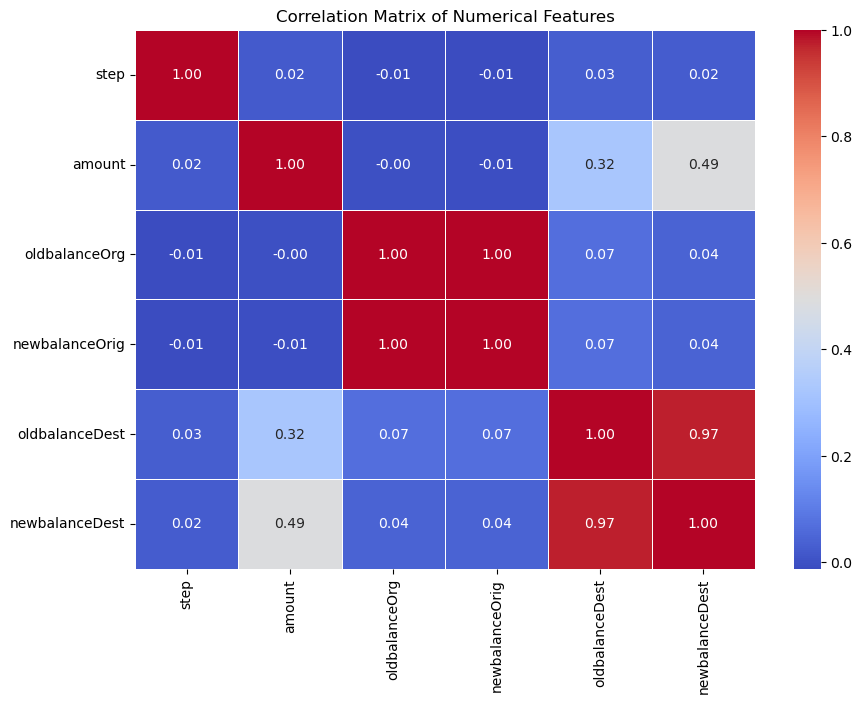

In [10]:
numeric_cols = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
plt.figure(figsize=(10, 7))
corr = df[numeric_cols].corr()

sns.heatmap(corr, annot=True, fmt=".2f",
            cmap='coolwarm', linewidths=0.5)

plt.title('Correlation Matrix of Numerical Features')
plt.show()

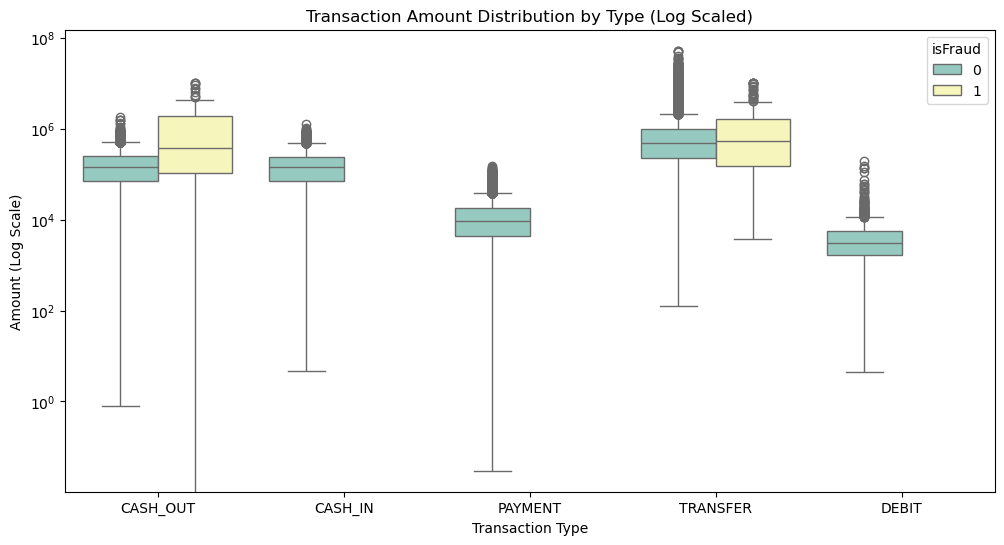

In [11]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='type', y='amount', hue='isFraud', 
            data=df, palette='Set3')

plt.yscale('log')
plt.title('Transaction Amount Distribution by Type (Log Scaled)')
plt.xlabel('Transaction Type')
plt.ylabel('Amount (Log Scale)')
plt.show()

In [12]:
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

In [13]:
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])

In [14]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())

Before SMOTE: isFraud
0    159773
1       226
Name: count, dtype: int64
After SMOTE: isFraud
0    159773
1    159773
Name: count, dtype: int64


In [18]:
#Random Forest Model
model = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    class_weight='balanced_subsample')
model.fit(X_train_res, y_train_res)

RandomForestClassifier(class_weight='balanced_subsample', random_state=42)

In [19]:
y_pred_rf = model.predict(X_test_scaled)
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

In [20]:
print("Evaluation of RandomForest")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}\n")
print(classification_report(y_test, y_pred_rf))
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")

Evaluation of RandomForest
Accuracy: 0.9987

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39944
           1       0.51      0.98      0.67        56

    accuracy                           1.00     40000
   macro avg       0.76      0.99      0.84     40000
weighted avg       1.00      1.00      1.00     40000

ROC-AUC: 0.9993


In [21]:
#KNN Model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_res, y_train_res)

KNeighborsClassifier()

In [22]:
y_pred_knn = knn_model.predict(X_test_scaled)
y_prob_knn = knn_model.predict_proba(X_test_scaled)[:, 1]

In [23]:
print("Evaluation of KNeighbors")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}\n")
print(classification_report(y_test, y_pred_knn))
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_knn):.4f}")

Evaluation of KNeighbors
Accuracy: 0.9890

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     39944
           1       0.09      0.79      0.17        56

    accuracy                           0.99     40000
   macro avg       0.55      0.89      0.58     40000
weighted avg       1.00      0.99      0.99     40000

ROC-AUC: 0.9070


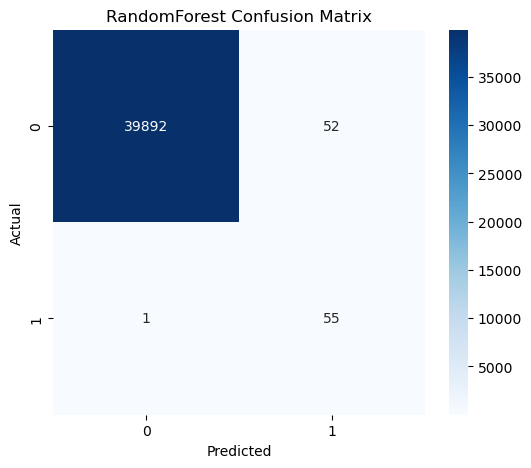

In [24]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6,5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
plt.title("RandomForest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

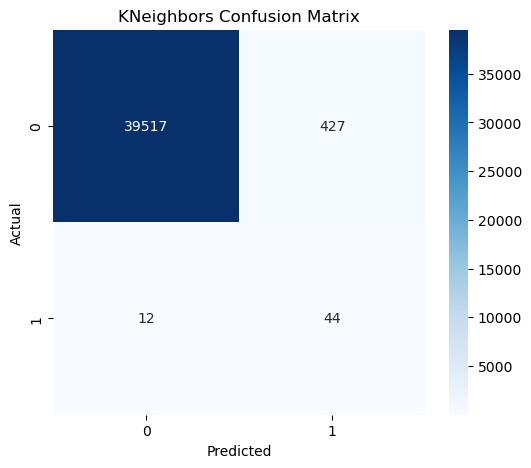

In [25]:
cm_knn = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(6,5))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues")
plt.title("KNeighbors Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()